# ASSIGNMENT 2-2

In [190]:
%matplotlib widget

In [191]:
import torch
import matplotlib.pyplot as plt

<img src="img/assign-2/assign_2-2.png" alt="alt text" style="width:15cm;"/>

In [192]:
# initialize matP and mat R
matP = torch.zeros(10,10,2)
matR = torch.zeros(10,10,2) # for simplicity reward in state where action is not applicable is set to 0 (it is not general)

# initialize matP for a1 and a2
tmpP1 = torch.zeros(10,10)
tmpP2 = torch.zeros(10,10)

# compute mat P for a1
for i in range(10):
    if i == 0:
        tmpP1[i, i] = 0.1
        tmpP1[i, i+1] = 0.9
    elif i == 9:
        tmpP1[i, i-1] = 0.05
        tmpP1[i, i] = 0.95
    else:
        tmpP1[i, i-1] = 0.05
        tmpP1[i, i] = 0.05
        tmpP1[i, i+1] = 0.9

# compute mat P for a2
for i in range(10):
    if i == 0:
        tmpP2[i, i] = 1
    else:
        tmpP2[i, i-1] = 1

# compute matP
matP[:,:,0] = tmpP1.clone()
matP[:,:,1] = tmpP2.clone()

# compute mat R
matR[0,0,1] = 0.5
matR[9,9,0] = 1

print("State transition probability matrix for a1 is \n", tmpP1.numpy())
print("State transition probability matrix for a2 is \n", tmpP2.numpy())

print("Reward matrix for a1: \n", matR[:,0].numpy())
print("Reward matrix for a2: \n", matR[:,1].numpy())

del tmpP1, tmpP2

# gamma list
gamma_list = [0.8,0.9,0.99]

State transition probability matrix for a1 is 
 [[0.1  0.9  0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.05 0.05 0.9  0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.05 0.05 0.9  0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.05 0.05 0.9  0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.05 0.05 0.9  0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.05 0.05 0.9  0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.05 0.05 0.9  0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.05 0.05 0.9  0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.05 0.05 0.9 ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.05 0.95]]
State transition probability matrix for a2 is 
 [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
Reward matrix for a1: 
 [[0.  0.5]
 [0.  0

In [193]:
def epsilon_greedy_action(matQ_:torch.Tensor, _state:int, _epsilon:float) -> int:
    """ Epsilon greedy action selection """
    
    if torch.rand(1).item() > _epsilon:
        # exploitation
        _idx_action = matQ_[_state,:].argmax().item()
    else:
        # exploration
        _available_action = torch.nonzero((matQ_[_state, :] != 0))
        _idx_action = _available_action[torch.randint(len(_available_action), (1,))].item()
        
    return _idx_action

## 2-a

In [ ]:
# SARSA
def sarsa_woT_algo(matP_:torch.Tensor, matR_:torch.Tensor, gamma_:float, epsilon_:float, step_size_:float=0.001,
               epsilon_decay_:float=0.001, alpha_decay_:float=0.001, iter_:int=1000, break_traj:int=100) -> list[torch.Tensor]:
    """ SARSA algorithm to estimate the value function of a policy """
    
    td_error_list_ = []
        
    # initialize action value function
    _matQ = torch.rand(10,2)*0.1 #initial guess of action value function
    
    # use only available action
    _mask_Q = (matP_[:, :, :] != 0).any(dim=1)
    _matQ[~_mask_Q] = 0 
    
    for n_ in range(iter_):
        
        traj = []   # trajectory of states
        rews = []   # trajectory of rewards
        acts = []   # trajectory of actions
        
        # initial state randomly selected
        state_ = torch.randint(10,(1,)).item() 
        
        epsilon_n = epsilon_/(1+epsilon_decay_*n_)
        alpha_ = step_size_/(1+alpha_decay_*n_)
        
        select_action = epsilon_greedy_action(_matQ, state_, epsilon_n)

        # generate episode using pi
        while len(traj) < break_traj:
            
            # select next state in probability
            pp = torch.rand(1).item() # random number in [0,1)
            mem_p = 0 # probability mass
            pi = 0 # index of action
            fl_continue = True
            
            while fl_continue:
                # select next action
                mem_p = mem_p + matP_[state_, pi, select_action].float() 
                if pp < mem_p:
                    # select next state
                    next_state = pi
                    fl_continue = False
                else:
                    pi += 1
                    
            reward = matR_[state_, next_state, select_action]

            # update lists
            traj.append(state_)
            acts.append(select_action)
            rews.append(reward)
            
            next_action = epsilon_greedy_action(_matQ, next_state, epsilon_n)
            
            # compute TD error              
            td_error = reward + gamma_*_matQ[next_state, next_action] - _matQ[state_, select_action]
            td_error_list_.append(td_error)
            
            # update action value function
            _matQ[state_, select_action] = _matQ[state_, select_action] + alpha_*(td_error)
            state_ = next_state
            select_action = next_action
    
    return _matQ, td_error_list_, rews

# matQ, e_list, _ = sarsa_woT_algo(matP, matR, 0.99, epsilon_=0.1, step_size_=0.1,
#                               epsilon_decay_=0.0, alpha_decay_=0.0001, iter_=10000, break_traj=100)

Parameters: epsilon_=0.1, step_size_=0.1, epsilon_decay_=0.0, alpha_decay_=0.0001, iter_=10000, break_traj=100

gamma =  0.8
Best action for each state is  [1 1 1 1 0 0 0 0 0 0]
Best policy: 
 tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]])
gamma =  0.9
Best action for each state is  [1 1 1 0 0 0 0 0 0 0]
Best policy: 
 tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]])
gamma =  0.99
Best action for each state is  [0 0 0 0 0 0 0 0 0 0]
Best policy: 
 tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]])


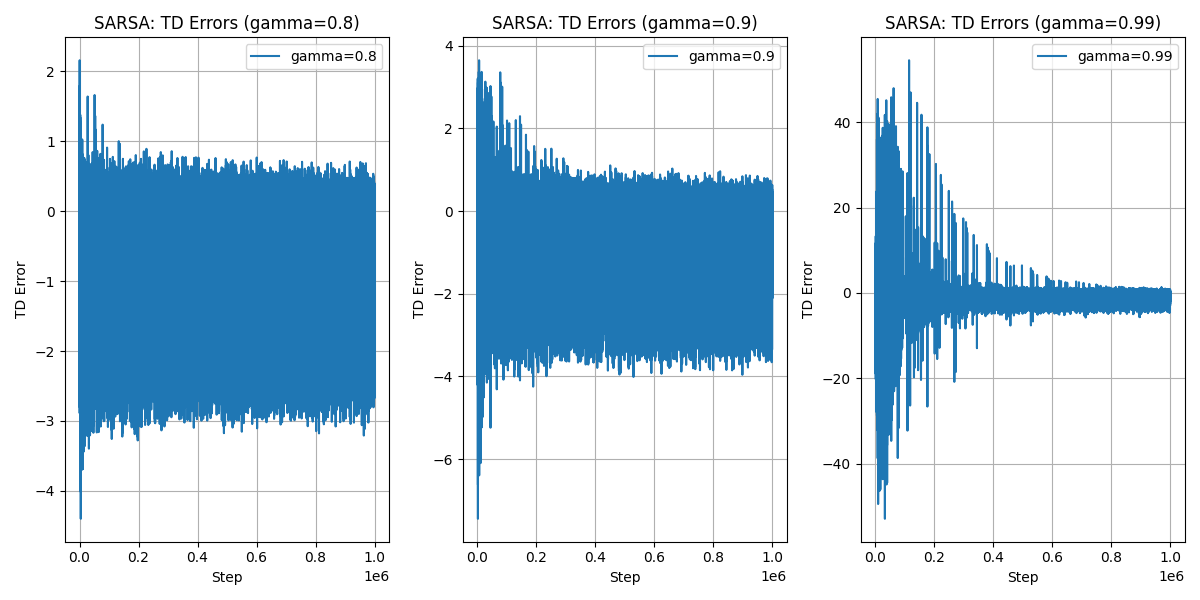

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(6, 10))
axes:list[plt.Axes] = axes.flatten()

for idx, gamma in enumerate(gamma_list):
    matQ, e_list, _ = sarsa_woT_algo(matP, matR, gamma, epsilon_=0.1, step_size_=0.1,
                                  epsilon_decay_=0.0, alpha_decay_=0.0001, iter_=10000, break_traj=100)
    
    best_action = matQ.argmax(dim=1)
    best_policy = torch.zeros(10,2)
    best_policy[torch.arange(10), best_action] = 1

    print("gamma = ", gamma)
    print("Best action for each state is ", (best_action).numpy().squeeze())
    print("Best policy: \n", best_policy)
    
    axes[idx].plot(e_list, label=f'gamma={gamma}')
    axes[idx].legend()
    axes[idx].set_title(f'SARSA: TD Errors (gamma={gamma})')
    axes[idx].set_xlabel('Step')
    axes[idx].set_ylabel('TD Error')
    axes[idx].grid()

plt.tight_layout()
plt.show()

With higher gamma the TD errors assume higher values and the convergence is slower.

<img src="img/assign-2/2-b.png" alt="alt text" style="width:15cm;"/>

## 2-b

In [199]:
# Q-learning
def qlearning_woT_algo(matP_:torch.Tensor, matR_:torch.Tensor, gamma_:float, epsilon_:float, step_size_:float=0.001,
               epsilon_decay_:float=0.001, alpha_decay_:float=0.001, iter_:int=1000, break_traj=100) -> list[torch.Tensor]:
    """ Q-learning algorithm to estimate the value function of a policy """
    
    td_error_list_ = []
        
    # initialize action value function
    _matQ = torch.rand(10,2)*0.1 #initial guess of action value function
    
    # use only available action
    _mask_Q = (matP_[:, :, :] != 0).any(dim=1)
    _matQ[~_mask_Q] = 0 
    
    for n_ in range(iter_):
        
        traj = []   # trajectory of states
        rews = []   # trajectory of rewards
        acts = []   # trajectory of actions
        
        # initial state randomly selected
        state_ = torch.randint(10,(1,)).item() 
        
        epsilon_n = epsilon_/(1+epsilon_decay_*n_)
        alpha_ = step_size_/(1+alpha_decay_*n_)
        
        select_action = epsilon_greedy_action(_matQ, state_, epsilon_n)

        # generate episode using pi
        while len(traj) < break_traj:
            
            # select next state in probability
            pp = torch.rand(1).item() # random number in [0,1)
            mem_p = 0 # probability mass
            pi = 0 # index of action
            fl_continue = True
            
            while fl_continue:
                # select next action
                mem_p = mem_p + matP_[state_, pi, select_action].float() 
                if pp < mem_p:
                    # select next state
                    next_state = pi
                    fl_continue = False
                else:
                    pi += 1
                    
            reward = matR_[state_, next_state, select_action]

            # update lists
            traj.append(state_)
            acts.append(select_action)
            rews.append(reward)
            
            # select best action wrt Q
            best_action = epsilon_greedy_action(_matQ, next_state, _epsilon=0.0)
            
            # compute TD error              
            td_error = reward + gamma_*_matQ[next_state, best_action] - _matQ[state_, select_action]
            td_error_list_.append(td_error)
            
            # update action value function
            _matQ[state_, select_action] = _matQ[state_, select_action] + alpha_*(td_error)
            state_ = next_state
            # we follow a
            select_action = epsilon_greedy_action(_matQ, state_, epsilon_n)
    
    return _matQ, td_error_list_, rews

Parameters: epsilon_=0.1, step_size_=0.1, epsilon_decay_=0.0, alpha_decay_=0.0001, iter_=10000, break_traj=100

gamma =  0.8
Best action for each state is  [1 1 1 1 0 0 0 0 0 0]
Best policy: 
 tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]])
gamma =  0.9
Best action for each state is  [1 1 1 0 0 0 0 0 0 0]
Best policy: 
 tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]])
gamma =  0.99
Best action for each state is  [0 0 0 0 0 0 0 0 0 0]
Best policy: 
 tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]])


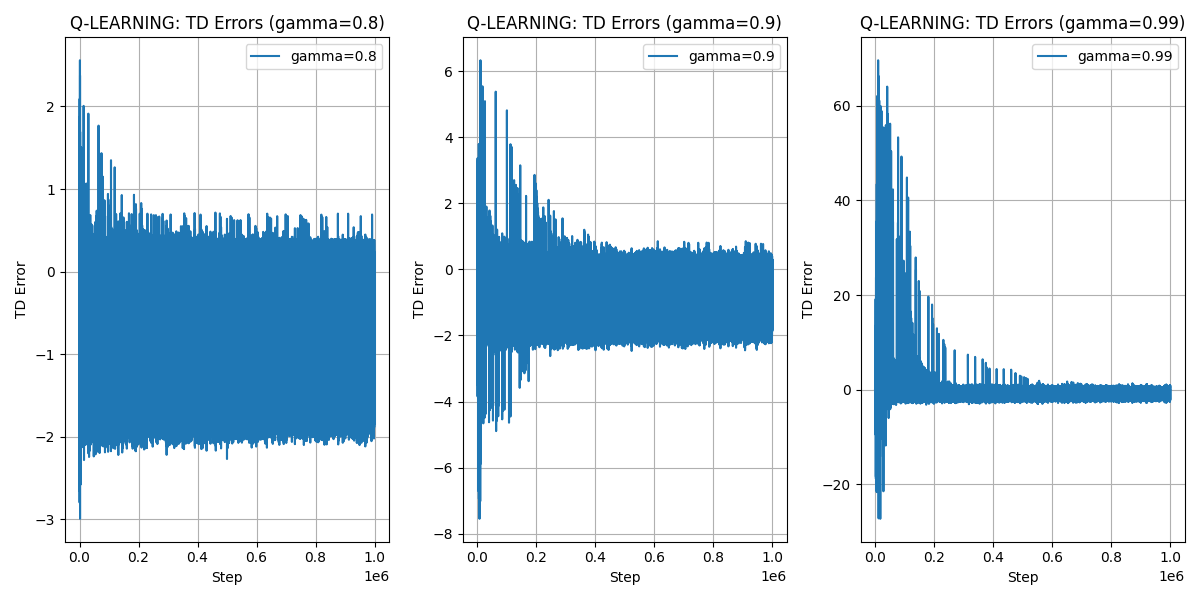

In [200]:
fig, axes = plt.subplots(3, 1, figsize=(6, 10))
axes:list[plt.Axes] = axes.flatten()

for idx, gamma in enumerate(gamma_list):
    matQ, e_list, _ = qlearning_woT_algo(matP, matR, gamma, epsilon_=0.1, step_size_=0.1,
                                  epsilon_decay_=0.0, alpha_decay_=0.0001, iter_=10000, break_traj=100)
    
    best_action = matQ.argmax(dim=1)
    best_policy = torch.zeros(10,2)
    best_policy[torch.arange(10), best_action] = 1

    print("gamma = ", gamma)
    print("Best action for each state is ", (best_action).numpy().squeeze())
    print("Best policy: \n", best_policy)
    
    axes[idx].plot(e_list, label=f'gamma={gamma}')
    axes[idx].legend()
    axes[idx].set_title(f'Q-LEARNING: TD Errors (gamma={gamma})')
    axes[idx].set_xlabel('Step')
    axes[idx].set_ylabel('TD Error')
    axes[idx].grid()

plt.tight_layout()
plt.show()

With higher gamma the TD errors assume higher values and the convergence is slower.